In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simpleGenerator import Croupier

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика

In [2]:
casino = Croupier()
for i in range(10):
    print(casino())

(6, 'U')
(1, 'U')
(6, 'U')
(6, 'U')
(6, 'U')
(6, 'U')
(1, 'U')
(3, 'U')
(3, 'U')
(5, 'U')


Сгенерируем датасеты размером 1 000, 10 000 и 100 000

In [3]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

In [15]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

In [40]:
maxTest = '635436264122216121166516221264525536451243665113143661236523635545112445646664323562213662665652325311324452216621324415116543422553662163611651433456554141642642361426626616565566461666625156664314325214311663655611166426415516646661422243665523156644655236152242555234632424521651115646514563454345'
maxLabel = 'LFFFFFFFFFFFFLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLFFFFFFFFFFFLFLLLFFFFFFFFFFLFFFFFFFFFFFFLFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFLLLLLLLLLLLLFFFFFFFFLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF'
maxAnswer = 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF'

In [41]:
maxData = [int(i) for i in maxTest]
maxLab = ['F' if l == 'F' else 'U' for l in maxLabel]
maxAns = ['F' if l == 'F' else 'U' for l in maxAnswer]

In [37]:
sum(l==r for l,r in zip(maxLab, result))

242

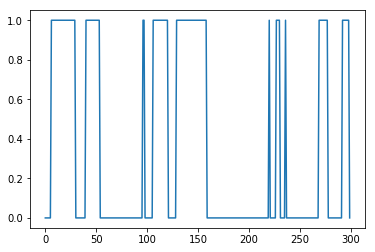

In [5]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

Определим базовый класс алгоритма

In [6]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

In [7]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

In [ ]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.8066666666666666
Probability: 1.1079234091770136e-238


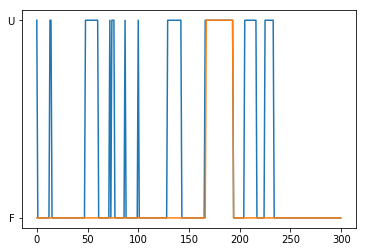

In [38]:
hackCasinoViterbi = algorithmViterbi(maxData)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(maxLab)
plt.plot(res)
print('RESULT: {}'.format( sum(l==r for l,r in zip(maxLab, result))/len(maxData)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

In [42]:
print('RESULT: {}'.format( sum(l==r for l,r in zip(maxAns, result))/len(maxData)))

RESULT: 1.0


RESULT: 0.687
Probability: 0.0


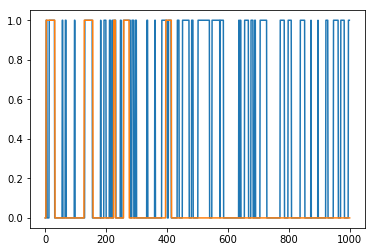

In [36]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

In [11]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [12]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.8066666666666666
Probability: 1.1079234091770136e-238


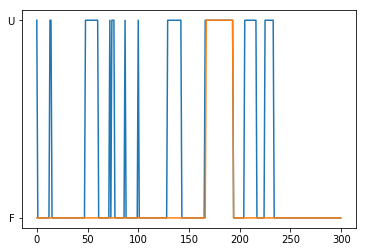

In [39]:
hackCasinoViterbi = algorithmViterbi(maxData)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(maxLab)
plt.plot(res)
print('RESULT: {}'.format( sum(l==r for l,r in zip(maxLab, result))/len(maxData)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.86
Probability: 2.5616090878884953e-235


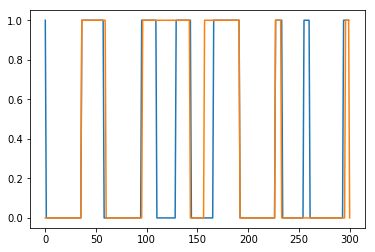

In [67]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.748
Probability: 2.5616090878884953e-235


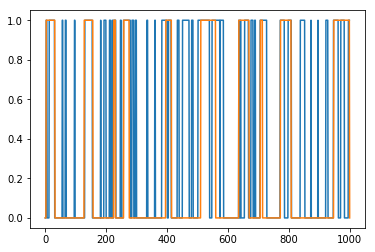

In [69]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

In [7]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

In [1]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.f = []
        self.pathProbability = None
    
    def step(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.step(i)
        self.pathProbability = sum(self.f[-1])

NameError: name 'baseAlgo' is not defined

In [9]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.b = []
        self.pathProbability = None
    
    def step(self, index):
        self.b.append([])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.b[-2]
            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,1,-1):
            self.step(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbability = sum([
            self.transitionsProbability[state]*self.diceValueProbability[state][self.data[0] - 1] 
            for state in self.states] * np.array(self.b[0]) * [val for val  in self.startProbability.values()]) 
        self.pathProbability = sum(self.pathProbability)

In [10]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\nRELATION B/F: {}'.format(f,b,f/b))

FORWARD: 4.312457644119492e-226
BACKWARD: 2.806795585646087e-226
RELATION B/F: 1.5364345256111058


In [11]:
class PosteriorDecoding(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        
        # For decoding
        self.conditionalProbability = None
        
    def stepForward(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackwardDecoding(self, index):
        ### backward step
        self.bCurrent = []
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.bPrevious
            probability = sum(transitionProbability * observedProbability * nextState)
            self.bCurrent.append(probability)
        
        ### decoding step
        # Будем смотреть на вероятность честного состояния
        conProb = self.f[index][0]*self.bCurrent[0] / self.pathProbability
        self.conditionalProbability.append(conProb)
        self.bPrevious = self.bCurrent
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        self.bPrevious = [1,1]
        
        for i in range(self.L-1,1,-1): # С двойки?
            self.stepBackwardDecoding(i)

In [12]:
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]

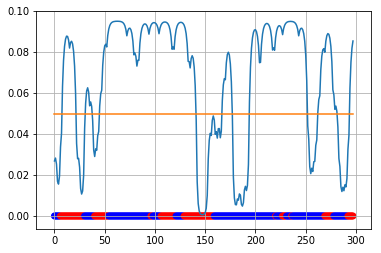

In [13]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
# Настроить оси
ax.plot([.05 for i in conditionsProbs])
#ax.plot([1 for i in conditionsProbs])
#ax.plot([0 for i in conditionsProbs])

In [28]:
class PosteriorDecodingScaled(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        
        # For decoding
        self.conditionalProbability = None
        
        # For scaling
        self.s = []
        
    def stepForward(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            scaledCoeff = sum( [self.diceValueProbability[state][self.data[index] - 1] for state in self.states] *
                              np.array(sum(previuosState * transitionProbability)))
            
            probability = observedProbability * sum(previuosState * transitionProbability) / scaledCoeff
            self.f[-1].append(probability)
            self.s.append(scaledCoeff)
    
    def stepBackwardDecoding(self, index):
        ### backward step
        self.bCurrent = []
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.bPrevious
            probability = sum(transitionProbability * observedProbability * nextState) / self.s[index]
            self.bCurrent.append(probability)
        
        ### decoding step
        # Будем смотреть на вероятность честного состояния
        conProb = self.f[index][0]*self.bCurrent[0] / self.pathProbability
        self.conditionalProbability.append(conProb)
        self.bPrevious = self.bCurrent
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states]) # Не уверен
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        self.bPrevious = [1,1]
        
        for i in range(self.L-1,1,-1): # С двойки?
            self.stepBackwardDecoding(i)

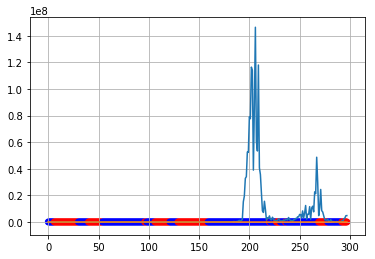

In [35]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
# Настроить оси
ax.plot([.05 for i in conditionsProbs])
#ax.plot([1 for i in conditionsProbs])
#ax.plot([0 for i in conditionsProbs])

In [ ]:
class parametrs:   # Сделаь универсальнее
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.5,0.5]), # to F, to U
            'U': np.array([0.5,0.5]) # to F, to U
        }
        
        self.startProbability = {
            'F': 1/2,
            'U': 1/2
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [1/6 for i in range(6)]
        }

In [ ]:
class BaumWelchTrainig(parametrs):
    def __init__(self, data):
        parametrs.__init__(self, data)

        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        
        self.epselon = 10**-100
        self.iterationNumber = 100
        
    def stepForward(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackward(self, index):
        ### backward step
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.b[-1]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b.append(probability)
            
    def initializationForwardBack(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states]) # Не уверен
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        self.b.append([1,1])
        ### Backward part ###
        for i in range(self.L-1,1,-1): # С двойки?
            self.stepBackward(i)
    
    
    def __call__(self):
        if self.isFitted == False: self.initialization()
        print('FITTED')
        print('Parametrs')
        print('TransitionsProbability: {}'.format(self.transitionsProbability))
        print('startProbability: {}'.format(self.startProbability))
        print('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initialization(self):
        prLog = 10000000000000
        for step in range(self.iterationNumber):
            # Calculate f and b
            self.f = []
            self.pathProbability = 0
            self.b = []
            self.initializationForwardBack()
            # Change paramets
            self.changeParametrs()
            currentLog = self.logLikelihood()
            if (abs(currentLog - prLog) < self.epselon: break
            prLog = currentLog
    
    
    def logLikelihood(self):
        return sum( [np.log(1)]
    
    def changeParametrs(self):
        Afair2fair = sum([ self.f[0][i] * self.b[0][i+1] *
                          self.transitionProbability['F'][0] *
                          self.diceValueProbability['F'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                          
        Afair2unfair = sum([ self.f[0][i] * self.b[1][i+1] *
                          self.transitionProbability['F'][1] *
                          self.diceValueProbability['F'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
        
        Aunfair2fair = sum([ self.f[1][i] * self.b[0][i+1] *
                          self.transitionProbability['U'][0] *
                          self.diceValueProbability['U'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                            
        Aunfair2unfair = sum([ self.f[1][i] * self.b[1][i+1] *
                          self.transitionProbability['U'][1] *
                          self.diceValueProbability['U'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                              
        # Add E